In [ ]:
import osmnx as ox
import pandas as pd
from osmnx.io import _stringify_nonnumeric_cols

In [ ]:
place_name = "Vaud, Switzerland"
dst_stops_filepath = "data/processed/public-transport-stops.gpkg"
dst_network_filepath = "data/processed/public-transport-network.gpkg"

## Public transportation stops

In [ ]:
tags = {"public_transport": "stop_position"}

# Retrieve the public transportation stops
stops_gdf = ox.geometries_from_place(place_name, tags)

In [ ]:
# Create a new column with a category for each stop depending on the transport mode to
# that end, we will look for "yes" values either in the "bus", "light_rail" or "train"
# columns - see https://wiki.openstreetmap.org/wiki/Public_transport
for column in "bus", "light_rail", "funicular", "train", "trolleybus":
    stops_gdf.loc[stops_gdf[stops_gdf[column] == "yes"].index, "category"] = column

<Axes: >

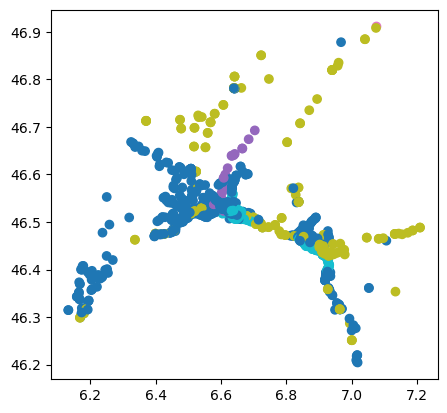

In [ ]:
stops_gdf.plot(column="category")

In [ ]:
# save it to a geopackage
stops_gdf.to_file(dst_stops_filepath)

## Public transportation network (except buses)

In [ ]:
# Get the nodes and edges of the public transportation network
# We filter out the `service=spur` to avoid including the Tridel tunel (no passenger
# service) - see https://fr.wikipedia.org/wiki/Tridel
G = ox.graph_from_place(
    place_name,
    custom_filter='["railway"~"light_rail|rail|subway|tram"]["service"!~"spur"]',
)

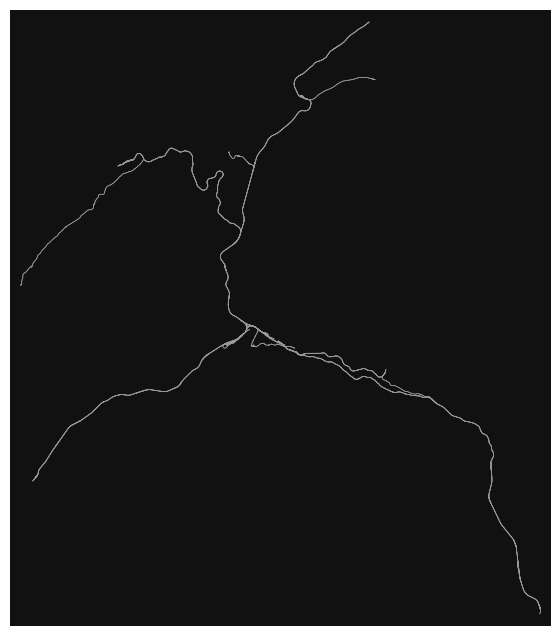

In [ ]:
# Plot the public transportation network
plot_kws = dict(node_size=0, edge_linewidth=0.5, edge_color="#999999")
fig, ax = ox.plot_graph(G, **plot_kws)

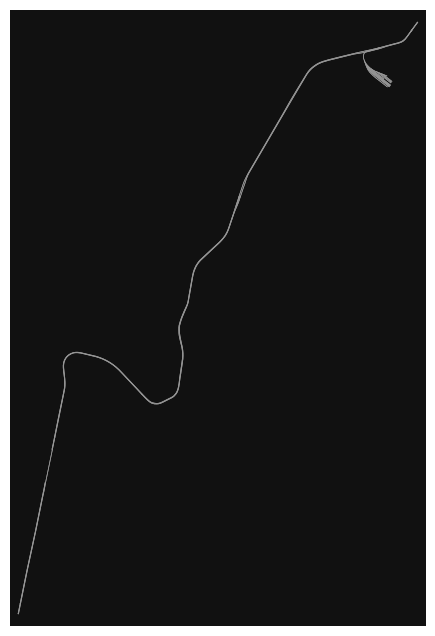

In [ ]:
# For some reason, the subway network is not included in G
G_subway = ox.graph_from_place(
    place_name,
    custom_filter='["railway"~"subway"]["service"!~"spur"]',
)
fig, ax = ox.plot_graph(G_subway, **plot_kws)

In [ ]:
# ox.save_graph_geopackage(G, filepath="transportation_network.gpkg")
# get the edges only
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes_subway, gdf_edges_subway = ox.graph_to_gdfs(G_subway)
# concat the non-subway and subway edges
gdf_edges_all = pd.concat([gdf_edges, gdf_edges_subway])
# stringify non-numeric cols (except geometry) to save a gpkg
gdf_edges_all = _stringify_nonnumeric_cols(gdf_edges_all)
# dump to geopackage
gdf_edges_all.to_file(dst_network_filepath)